# Prediction Model

In this notebook, I implement a time series forecasting model using ARIMA (AutoRegressive Integrated Moving Average) to predict future smoke estimates based on available historical data for 1964-2020. The model is designed to predict wildfire smoke estimates for the years 2020 to 2050. The notebook also calculates the Mean Squared Error (MSE) as a measure of the model's performance on test data, and shows some visualizations to undestand the model forecasts better.

In [2]:
#
#    IMPORTS
#

#    These are standard python modules. In case you do not have a python module, you should use `!pip install <module>`
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


In [3]:
# Load the data
smoke_estimate_aqi_data = pd.read_csv("../Processed Data/smoke_estimate_with_year_aqi.csv", index_col=0)
smoke_estimate_aqi_data.head()

,Fire_Year,Smoke_Estimate,yearly_avg_aqi
0,1964,4.341713,5.386648
1,1965,4.000000,6.132075
2,1966,6.274285,4.641221
3,1967,7.693339,53.584158
4,1968,6.949404,63.722527


Now, we split our smoke estimate data into training and test sets. We only have data from 1964-2020. The data for 2020 - 2024 does not exist in the USGS Dataset. Therefore, we also ensure that we drop any NaNs in the data.

I select 2012 as the boundary for my training set

In [4]:
# Split data into train and test sets
training_data = smoke_estimate_aqi_data[smoke_estimate_aqi_data['Fire_Year'] < 2012]['Smoke_Estimate']
test_data = smoke_estimate_aqi_data[smoke_estimate_aqi_data['Fire_Year'] >= 2012]['Smoke_Estimate']

# Handle NaN values in training and test data
training_data = training_data.dropna()
test_data = test_data.dropna()

# ARIMA Model
arima_model = ARIMA(training_data, order=(1,1,1)) # Using past 2 values for the prediction
arima_result = arima_model.fit()

# Make predictions
arima_pred = arima_result.predict(start=len(training_data), end=len(training_data) + len(test_data) - 1)

# Calculate Mean Squared Error
arima_mse = mean_squared_error(test_data, arima_pred)

# Print the MSE
print(f'Mean Squared Error: {arima_mse}')

Mean Squared Error: 146.40168501063158


c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         Smoke_Estimate   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -142.631
Date:                Wed, 04 Dec 2024   AIC                            291.261
Time:                        08:34:14   BIC                            296.812
Sample:                             0   HQIC                           293.350
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2947      0.350      0.842      0.400      -0.391       0.981
ma.L1         -0.6700      0.331     -2.024      0.043      -1.319      -0.021
sigma2        25.1853      4.495      5.603      0.0

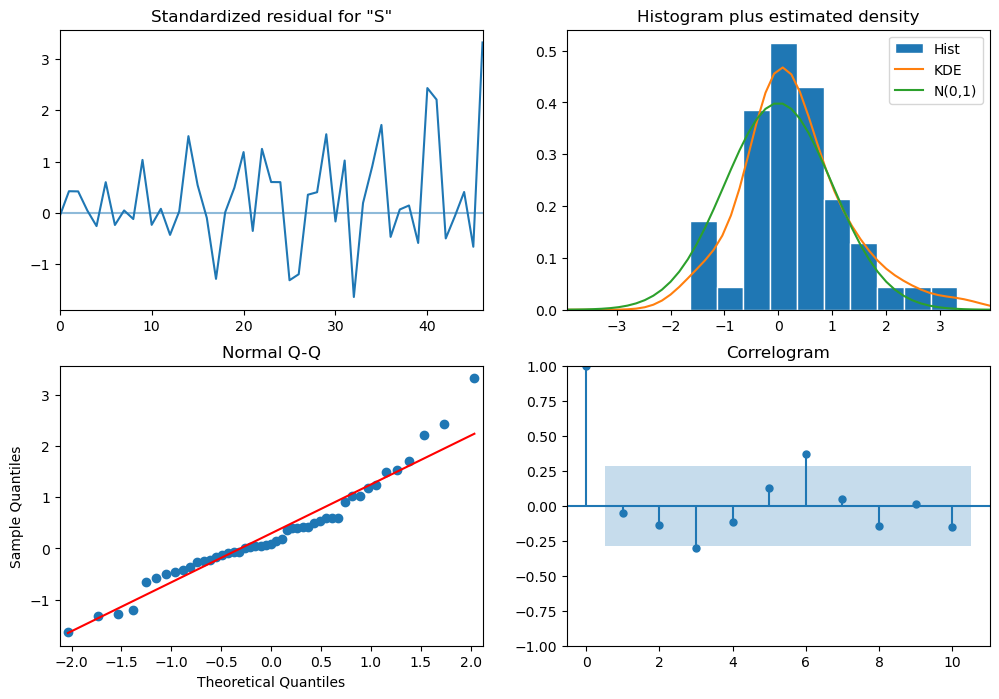

In [5]:
# Summarize the model results
print(arima_result.summary())
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

Now, we try and predict the smoke estimates for the years 2020-2050

c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihir\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


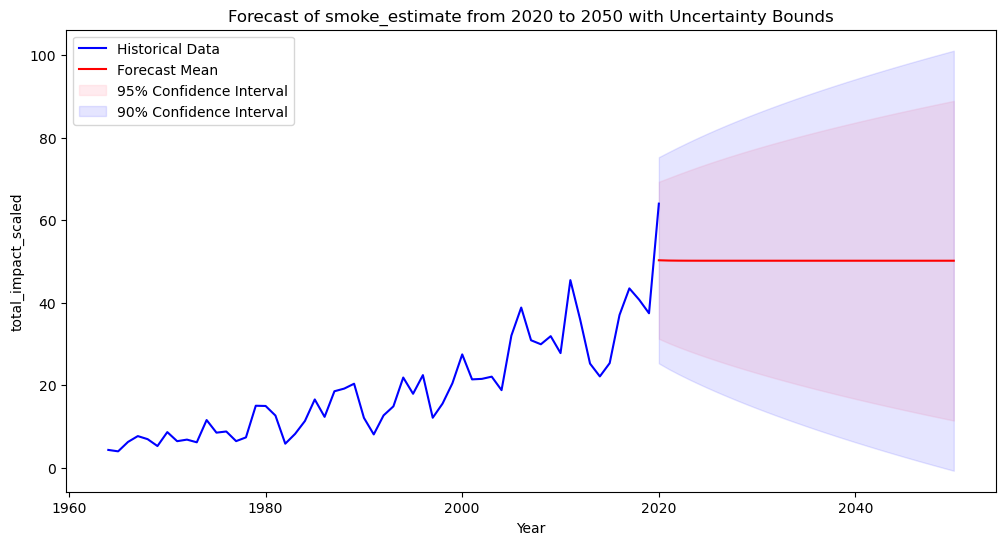

In [6]:
# Taken from Sushma's code
smoke_estimate_data = smoke_estimate_aqi_data["Smoke_Estimate"]

# Forecasting for 2020-2050 with ARIMA and calculating uncertainty bounds
forecast_years = range(2020, 2051)
n_forecasts = len(forecast_years)
forecast_result = ARIMA(smoke_estimate_data, order=(1, 1, 1)).fit()
forecast = forecast_result.get_forecast(steps=n_forecasts)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval
forecast_conf_int_2 = forecast.conf_int(alpha=0.01)  # 90% confidence interval

# Plotting historical data and forecast with uncertainty bounds
plt.figure(figsize=(12, 6))
plt.plot(smoke_estimate_aqi_data['Fire_Year'], smoke_estimate_aqi_data['Smoke_Estimate'], label='Historical Data', color='blue')
plt.plot(forecast_years, forecast_mean, label='Forecast Mean', color='red')
plt.fill_between(forecast_years, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.fill_between(forecast_years, forecast_conf_int_2.iloc[:, 0], forecast_conf_int_2.iloc[:, 1], color='blue', alpha=0.1, label='90% Confidence Interval')
plt.title("Forecast of smoke_estimate from 2020 to 2050 with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("total_impact_scaled")
plt.legend(loc='upper left')
plt.show()

In [7]:
forecast.predicted_mean

61    50.284022
62    50.215578
63    50.189524
64    50.179607
65    50.175831
66    50.174394
67    50.173847
68    50.173639
69    50.173560
70    50.173530
71    50.173518
72    50.173514
73    50.173512
74    50.173511
75    50.173511
76    50.173511
77    50.173511
78    50.173511
79    50.173511
80    50.173511
81    50.173511
82    50.173511
83    50.173511
84    50.173511
85    50.173511
86    50.173511
87    50.173511
88    50.173511
89    50.173511
90    50.173511
91    50.173511
Name: predicted_mean, dtype: float64

In [14]:

# Save the forecast results for 2021-2050 in a dataframe
forecast_years_2021_2050 = range(2021, 2051)
forecast_df_2021_2050 = pd.DataFrame({
    'Year': forecast_years_2021_2050,
    'Smoke_Estimate': forecast_mean.loc[62:91].values,
})

# Display the dataframe
display(forecast_df_2021_2050)
forecast_df_2021_2050.to_csv("../Processed Data/smoke_estimate_predictions.csv", index = False)

,Year,Smoke_Estimate
0,2021,50.215578
1,2022,50.189524
2,2023,50.179607
3,2024,50.175831
4,2025,50.174394
5,2026,50.173847
6,2027,50.173639
7,2028,50.173560
8,2029,50.173530
9,2030,50.173518


Based on the results above, we can see that the confidence intervals are very large, and that the smoke-estimates are pretty much constant throughout. This alongside the fact that the MSE score was so high, suggestion that ARIMA is probably not the best choice of model here since the data is very limited, and perhaps need to consider more paramters and a more sophisticated model like Polynomial Regression, ARIMAX or Prophet. 

Since the results above weren't that great, I decided to try a polynomial regression model to predict the smoke data

In [ ]:
smoke_estimate_aqi_data = smoke_estimate_aqi_data.dropna(subset=['Smoke_Estimate'])

# Create polynomial features
X = smoke_estimate_aqi_data[['Fire_Year']]
y = smoke_estimate_aqi_data['Smoke_Estimate']
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

Now that we have the model trained, I decided to make predictions on the historical data to confirm accuracy of model

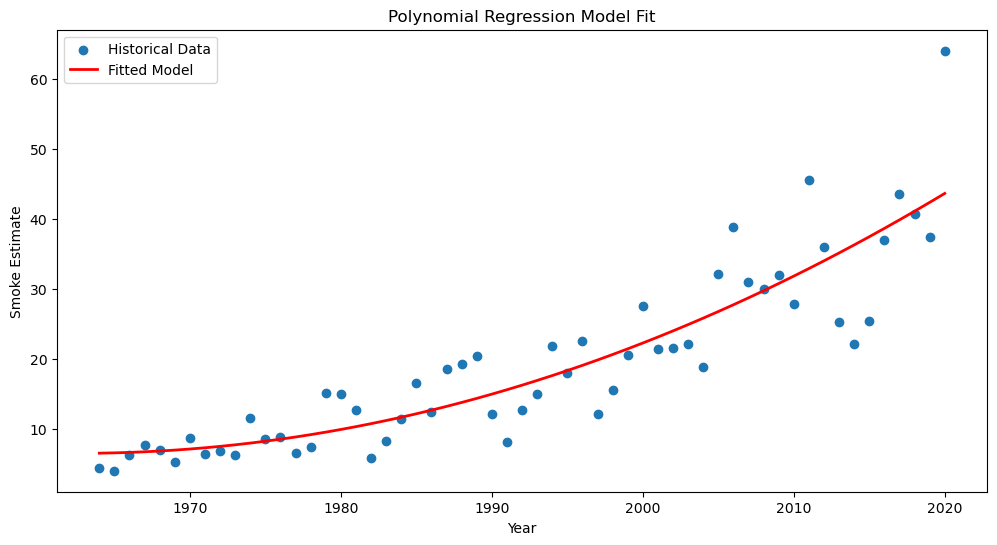

In [10]:
y_pred = model.predict(X_poly)

plt.figure(figsize=(12, 6))
plt.scatter(smoke_estimate_aqi_data['Fire_Year'], smoke_estimate_aqi_data['Smoke_Estimate'], label='Historical Data')
plt.plot(smoke_estimate_aqi_data['Fire_Year'], y_pred, color='red', label='Fitted Model', linewidth=2)
plt.title('Polynomial Regression Model Fit')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.show()

In [11]:
# Calculate model accuracy through mean squared error
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Squared Error (MSE): 31.1124


Now, based on the image and the MSE score, we can confirm that this model performs much better than the ARIMA model. Therefore, let's use this model to predict the future smoke estimates

c:\Users\mihir\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


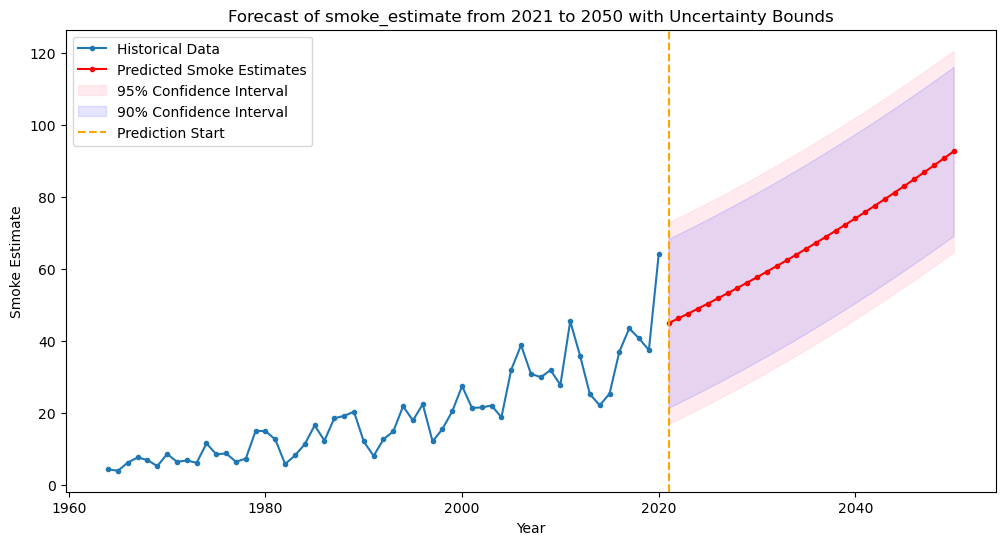

In [ ]:
# Some part of this model code was taken from Manasa Shivappa's code and used with appropriate modifications as necessary
future_years = np.arange(2021, 2051).reshape(-1, 1)
future_years_poly = poly.transform(future_years)
predictions = model.predict(future_years_poly)

years_combined = np.concatenate([X, future_years])
smoke_combined = np.concatenate([y.values, predictions])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(smoke_estimate_aqi_data['Fire_Year'], smoke_estimate_aqi_data['Smoke_Estimate'], label='Historical Data', linewidth=1.5, marker = '.')
plt.plot(future_years, predictions, color='red', label='Predicted Smoke Estimates', linewidth=1.5, marker = '.')

predictions_std = np.std(predictions)
confidence_interval_95 = 1.96 * predictions_std
confidence_interval_90 = 1.645 * predictions_std

# Plot confidence intervals
plt.fill_between(future_years.flatten(), predictions - confidence_interval_95, predictions + confidence_interval_95, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.fill_between(future_years.flatten(), predictions - confidence_interval_90, predictions + confidence_interval_90, color='blue', alpha=0.1, label='90% Confidence Interval')

plt.title("Forecast of smoke_estimate from 2021 to 2050 with Uncertainty Bounds")
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.axvline(x=2021, color='orange', linestyle='--', label='Prediction Start')
plt.legend(loc='upper left')
plt.show()

Now that we have the predictions, we can store this in a dataframe for later use

In [15]:

predicted_df = pd.DataFrame({
    'Fire_Year': future_years.flatten(),
    'Smoke_Estimate': predictions
})
display(predicted_df)
predicted_df.to_csv("../Processed Data/smoke_estimate_predictions.csv", index = False)

,Fire_Year,Smoke_Estimate
0,2021,44.919831
1,2022,46.247748
2,2023,47.598219
3,2024,48.971243
4,2025,50.366819
5,2026,51.784949
6,2027,53.225631
7,2028,54.688867
8,2029,56.174655
9,2030,57.682997


I have stored all prediction data in the processed data folder